In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'
animalname = os.path.basename(os.path.normpath(FolderName))
frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 4 #5cm bins

In [38]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [5]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 129
Number of PlaceCells in Task1 is 133
Number of PlaceCells in Task3 is 123
Number of PlaceCells in Task4 is 119
Number of PlaceCells in Task2a is 129


### Load required Data - load actual running data

#### Control Data

In [6]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

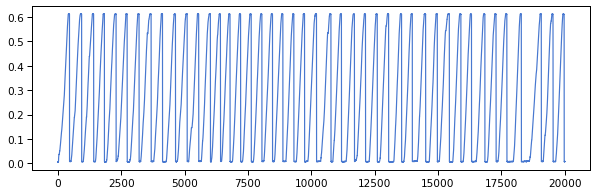

In [7]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [8]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

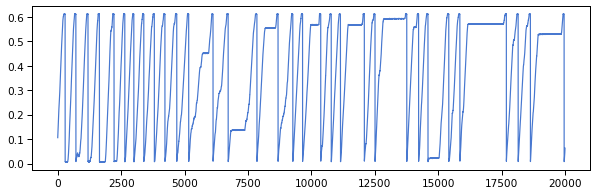

In [9]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

### Compare velocity of tasks and select laps with comparable speeds

Chosen speeds
Number of chosen laps : Task1 : 15, Task2 : 10
Remainin laps in 12
Task1 [12.23369916 11.23305358 11.07165913  9.97417689 10.16785023 10.78114913
  9.39315688 10.29696578 10.74887024  9.39315688 10.94254358  9.39315688
 10.29696578 12.97611362 10.61975468]
Task2 [12.91155584 10.5551969  11.4912847   9.6191091  11.78179471 13.10522918
  9.941898   10.45836023 11.55584248 13.23434474]
Worst lap speeds Task2
[13.29890252 28.98644287 17.43060039 34.05422853 25.01613944 16.91413815
 21.17495158 28.24402841 38.5087153  57.29502905 13.75080697 41.05874758]


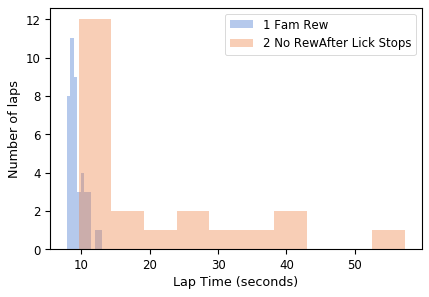

In [10]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_velocity_distribution(A, [TaskA, TaskB])
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0.3, after_stoplick=1)

In [11]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 40, 41]])

Data shapes :  (5711, 316) (5711, 1)
[ 1  2  4  5  7  9 10 11 13 23 26 33]
[11 26  4  9  1  2 33 13  5 10]
New data shapes :  (3683, 316) (3683, 1)


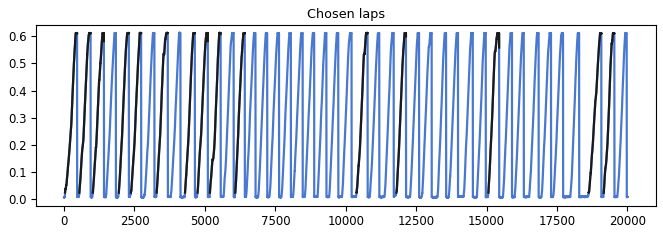

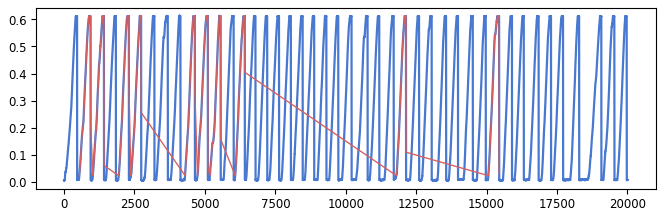

In [12]:
#Equalize laps between tasks
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (4108, 316) (4108, 1)


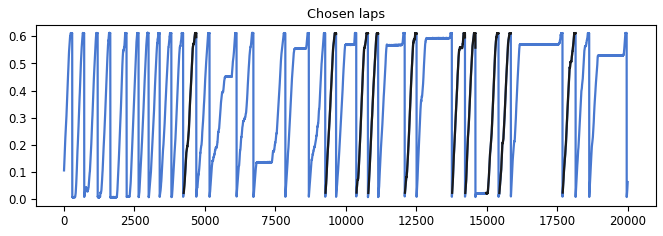

In [13]:
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=2, figureflag=1)

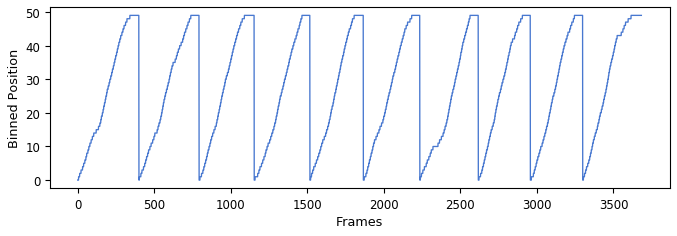

In [14]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_v_eq, tracklength=tracklength, trackbins=trackbins)
y_v_eq_cat = B.position_binary

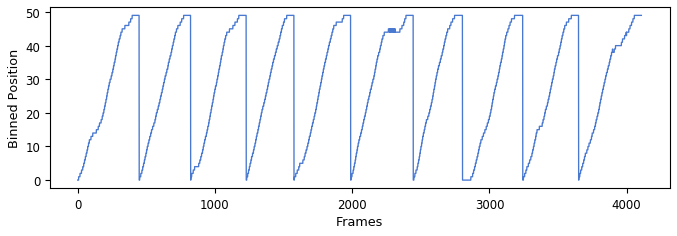

In [15]:
B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength, trackbins=trackbins)
y_v_cat_norew = B.position_binary

### Run Naive Bayes on chosen lap data

#### Control data

Data shapes :  (2946, 316) (737, 316) (2946,) (737,)

Accuracy of test set:: 0.32%


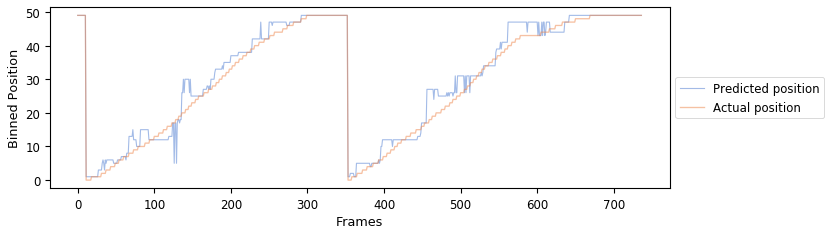

R2: 0.97
rho: 0.99




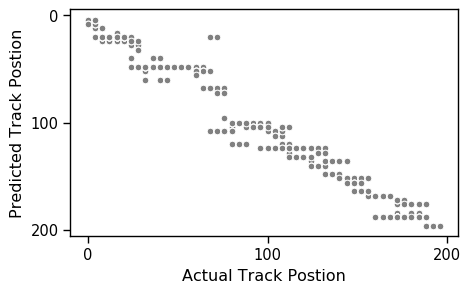

In [16]:
y_test, y_predicted = rnb.run_naivebayes(X_v_eq, y_v_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)

#### No reward Data

Data shapes :  (3286, 316) (822, 316) (3286,) (822,)

Accuracy of test set:: 0.23%


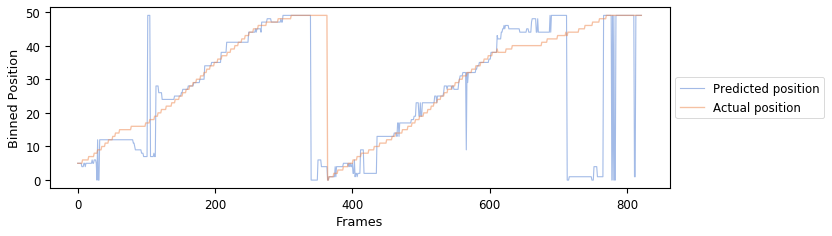

R2: 0.04
rho: 0.62




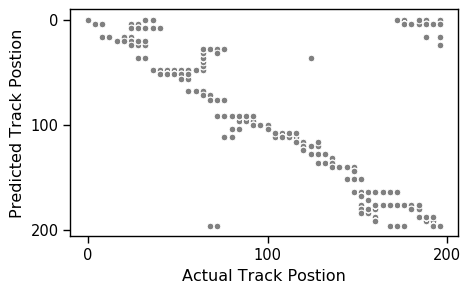

R2: 0.04
rho: 0.62




In [17]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_norew, y_v_cat_norew, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

### K-fold validation of tasks

In [18]:
nsplits = 5

#### Control Data

Performing 5-fold validation
Validation 1
(2946, 316) (2946,) (737, 316) (737,)

Accuracy of test set:: 0.33%


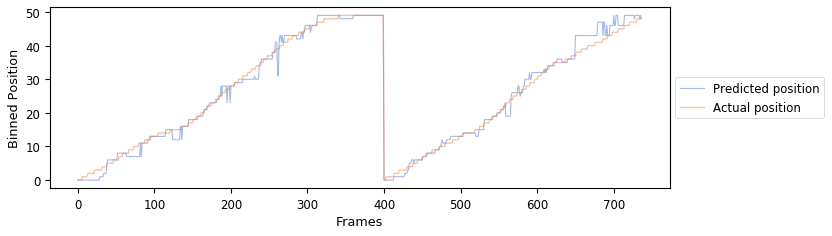

Validation 2
(2946, 316) (2946,) (737, 316) (737,)

Accuracy of test set:: 0.42%


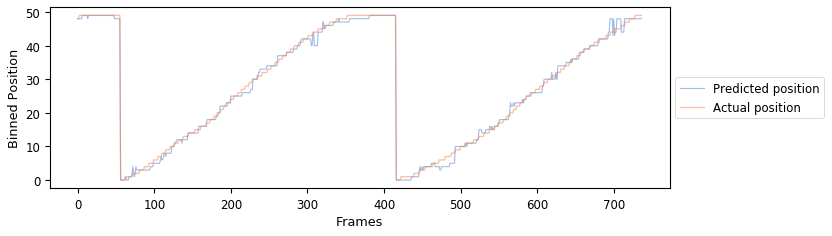

Validation 3
(2946, 316) (2946,) (737, 316) (737,)

Accuracy of test set:: 0.35%


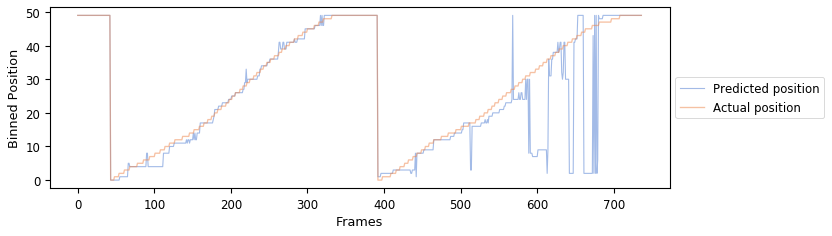

Validation 4
(2947, 316) (2947,) (736, 316) (736,)

Accuracy of test set:: 0.34%


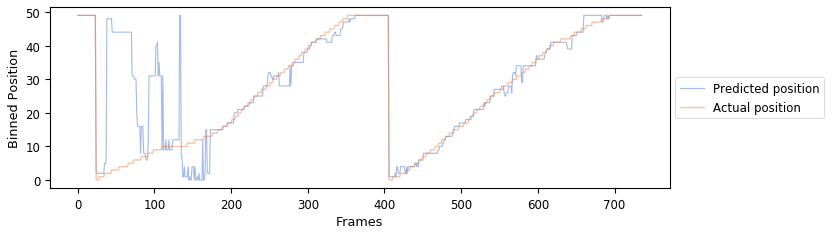

Validation 5
(2947, 316) (2947,) (736, 316) (736,)

Accuracy of test set:: 0.32%


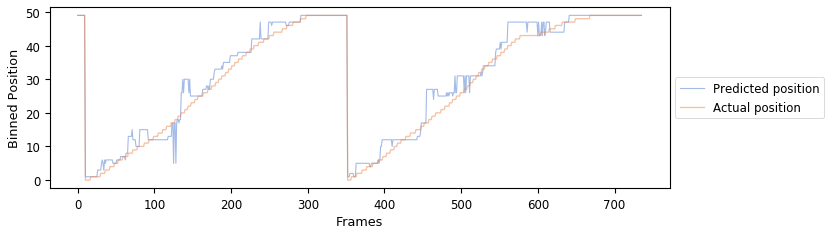

In [19]:
controlcv_dataframe = rnb.k_foldvalidation(X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=1)

Performing 5-fold validation
Validation 1
(3286, 316) (3286,) (822, 316) (822,)

Accuracy of test set:: 0.30%


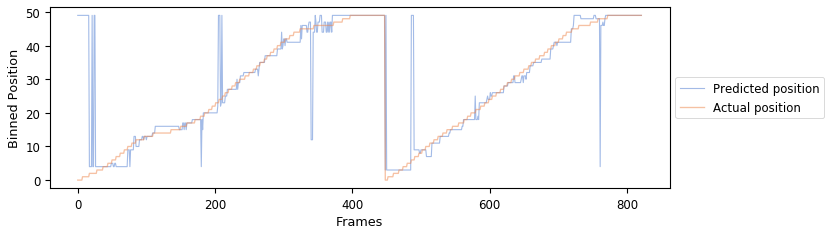

Validation 2
(3286, 316) (3286,) (822, 316) (822,)

Accuracy of test set:: 0.20%


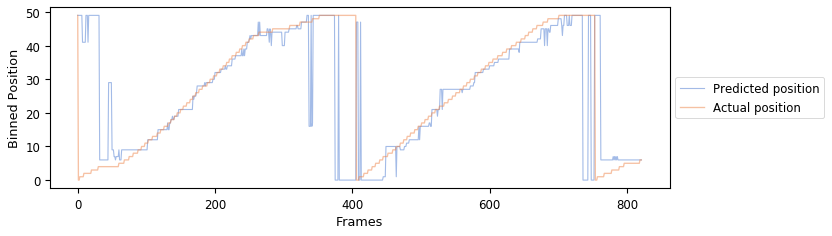

Validation 3
(3286, 316) (3286,) (822, 316) (822,)

Accuracy of test set:: 0.26%


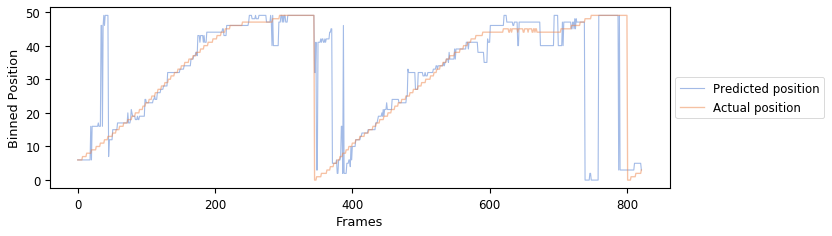

Validation 4
(3287, 316) (3287,) (821, 316) (821,)

Accuracy of test set:: 0.31%


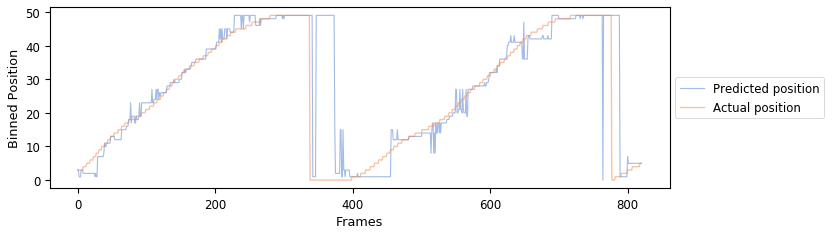

Validation 5
(3287, 316) (3287,) (821, 316) (821,)

Accuracy of test set:: 0.23%


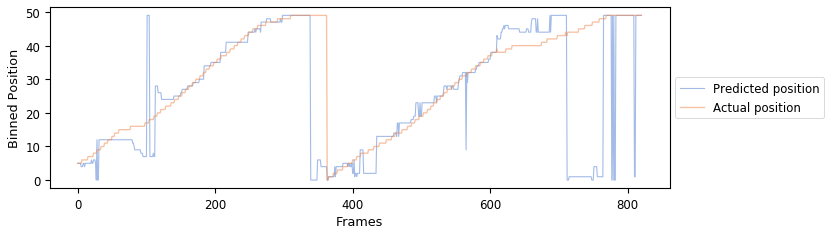

In [20]:
norewardcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=1)

### Compare Control with the worst but corrected laps

In [21]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

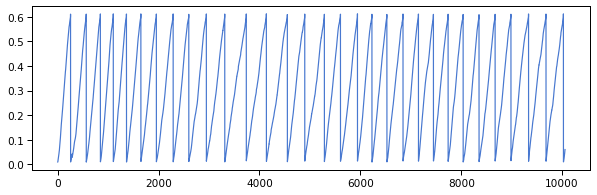

In [22]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

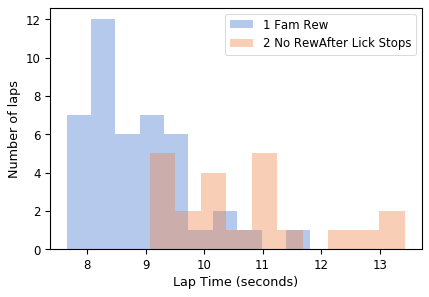

In [23]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_corrected_velocity_distribution(A, [TaskA, TaskB])

In [24]:
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Data shapes :  (4194, 316) (4194, 1)
[10 11 12 13 14 15 17 20 22 27 29 30]
[11 15 12 13 30 27 10 14 17 20]
New data shapes :  (3574, 316) (3574, 1)


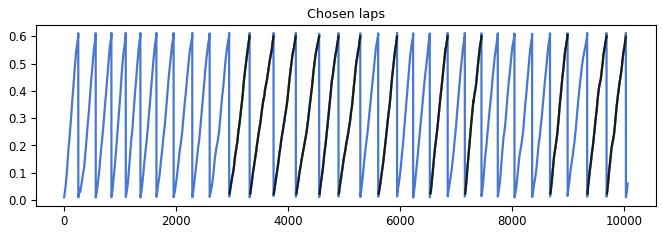

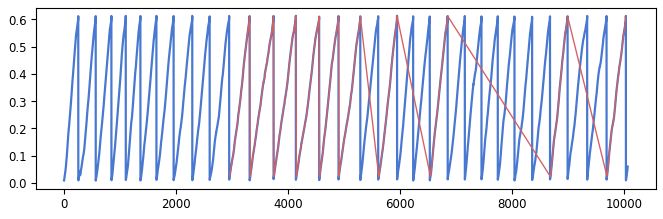

In [25]:
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)
X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1, lapcorrectionflag=1)

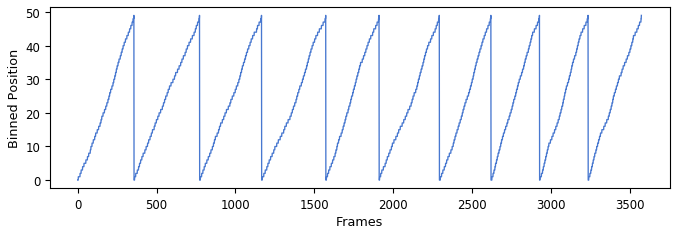

In [26]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength, trackbins=trackbins)
y_norew_goodlaps_eq_cat = B.position_binary

#### Run Bayes classifier on the corrected worst laps

Data shapes :  (2859, 316) (715, 316) (2859,) (715,)

Accuracy of test set:: 0.15%


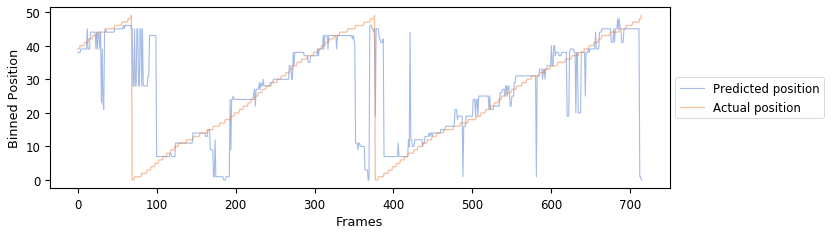

R2: 0.31
rho: 0.64




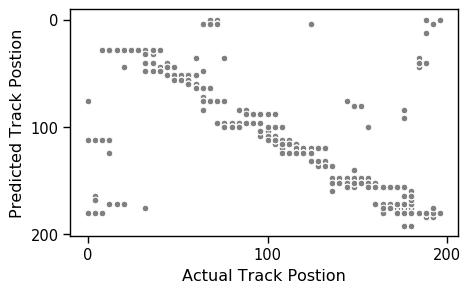

R2: 0.31
rho: 0.64




In [27]:
y_test, y_predicted = rnb.run_naivebayes(X_norew_goodlaps_eq, y_norew_goodlaps_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(2859, 316) (2859,) (715, 316) (715,)

Accuracy of test set:: 0.06%


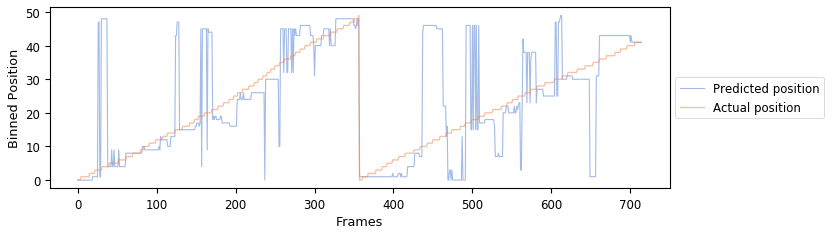

Validation 2
(2859, 316) (2859,) (715, 316) (715,)

Accuracy of test set:: 0.19%


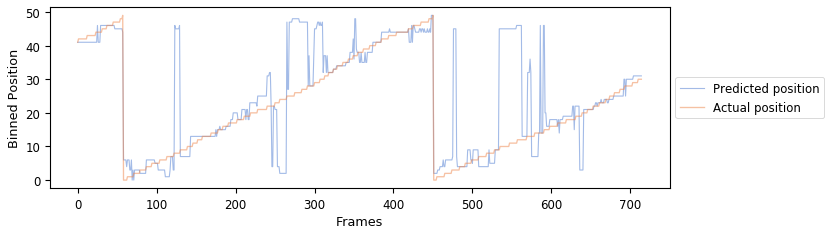

Validation 3
(2859, 316) (2859,) (715, 316) (715,)

Accuracy of test set:: 0.21%


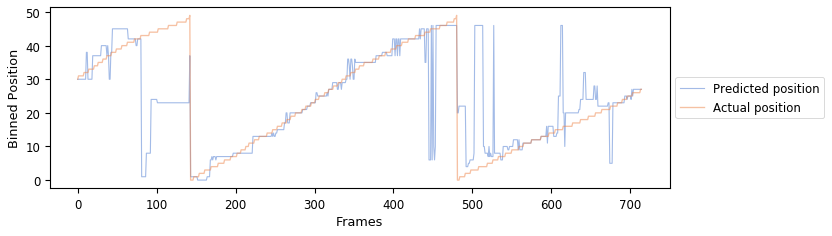

Validation 4
(2859, 316) (2859,) (715, 316) (715,)

Accuracy of test set:: 0.12%


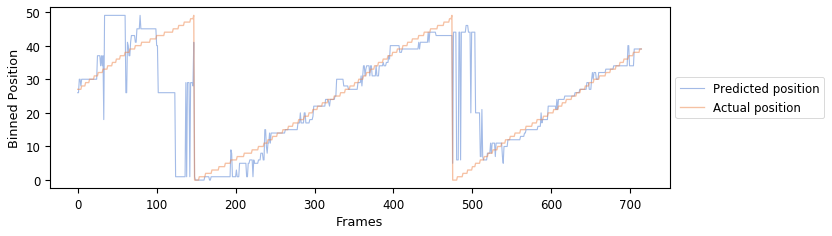

Validation 5
(2860, 316) (2860,) (714, 316) (714,)

Accuracy of test set:: 0.15%


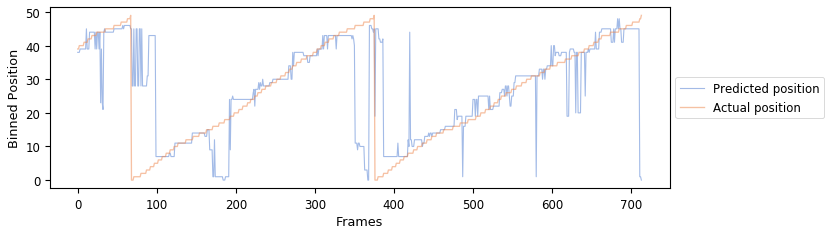

In [28]:
norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=1)

In [29]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['Animal'] = animalname

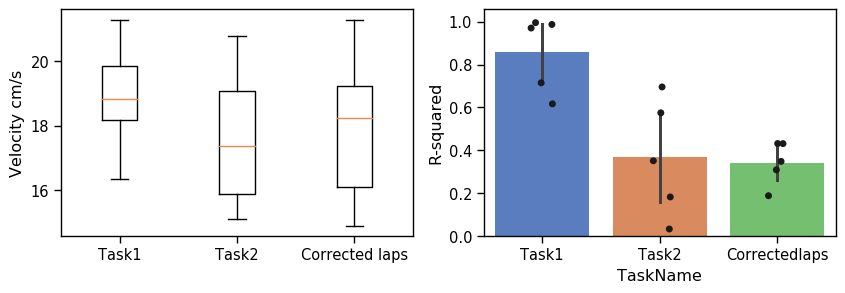

In [30]:
fs, ax1 = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');

### Decoding while lick is present

In [31]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[:stoplicklap]

Data shapes :  (2487, 316) (2487, 1)


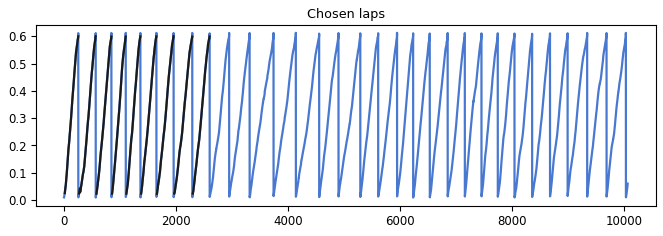

In [32]:
X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(stoplicklap), E_correction=1, lapcorrectionflag=1, figureflag=1)

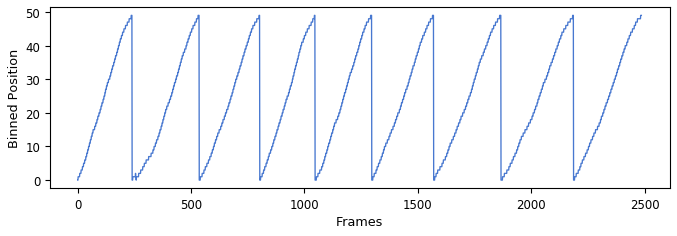

In [33]:
B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength, trackbins=trackbins)
y_v_new_lick_cat = B.position_binary

Data shapes :  (1989, 316) (498, 316) (1989,) (498,)

Accuracy of test set:: 0.27%


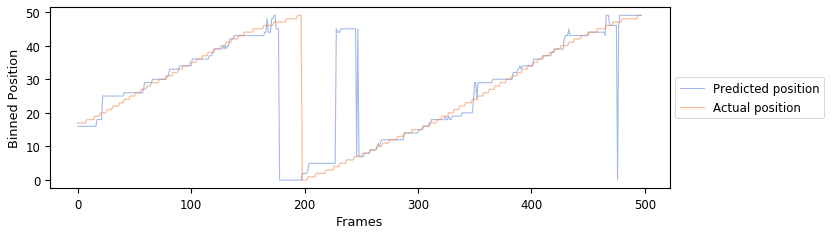

R2: 0.22
rho: 0.61




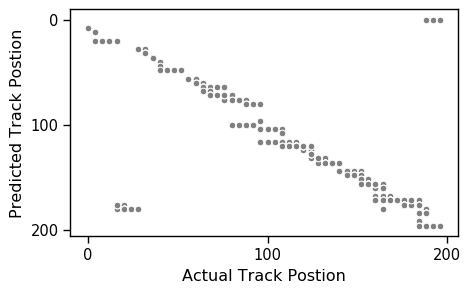

R2: 0.22
rho: 0.61




In [34]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_lick, y_v_new_lick_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.33%


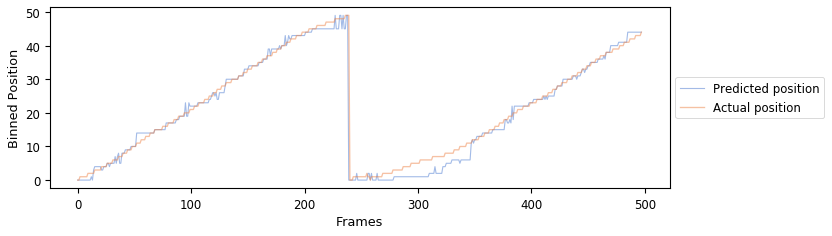

Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.34%


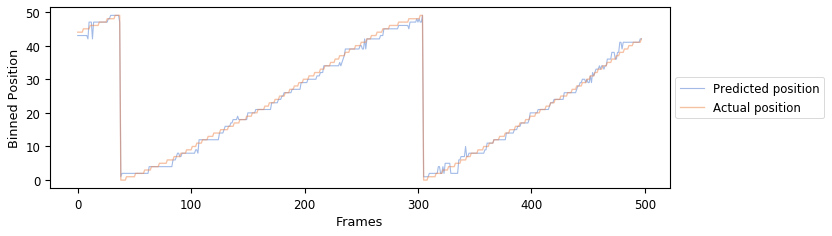

Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.36%


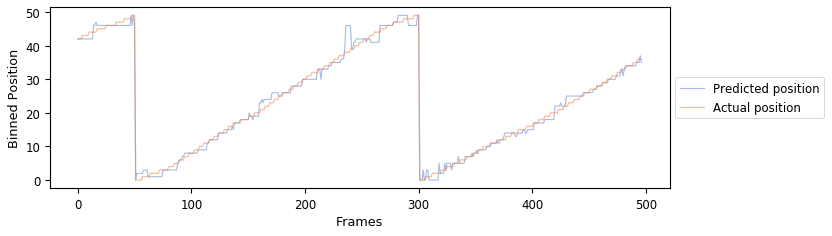

Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.34%


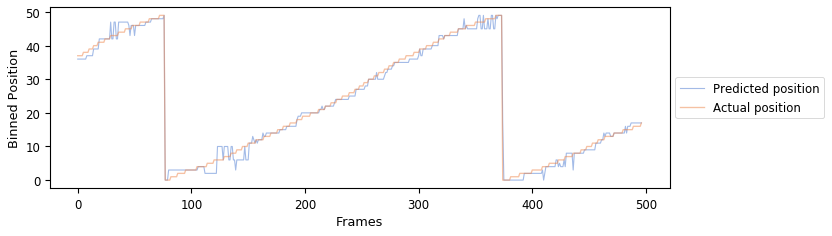

Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.29%


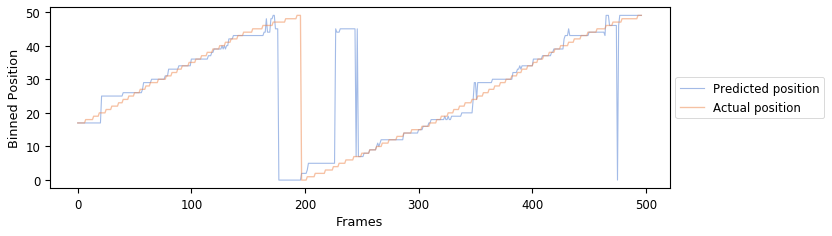

In [35]:
lickcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=1)

In [36]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2'], lickcv_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['TaskName'].iloc[nsplits*3:nsplits*4] = 'Task2_withlicks'
R2_dataframe['Animal'] = animalname

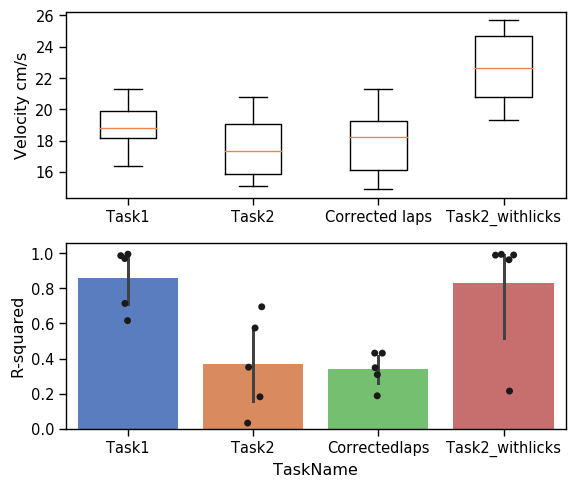

In [37]:
fs, ax1 = plt.subplots(2, 1, figsize=(6, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps, tracklength/laptime_lick], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps', 'Task2_withlicks'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save Results 

In [41]:
#Save R-squared dataframe
R2_dataframe.to_pickle(os.path.join(SaveResults, 'velocity_comparison_R2.pkl'))